In [42]:
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
import numpy as np

Let us first create a bivariate Gaussian distribution.

In [72]:
# We have two dimensions
D = 2

# Setup means
a_mu = 0
b_mu = 0

a_sigma = 1
b_sigma = 1
cov_a_b = 0.5

sigma = np.vstack(((a_sigma, cov_a_b), (cov_a_b, b_sigma)))
mu = np.vstack((a_mu, b_mu))

In [105]:
def p(x, mu, sigma):
    """Probability density function of a multivariate Gaussian"""
    return 1/(2*np.pi) * np.power(np.linalg.det(sigma), -1/2) * np.exp(- 1/2 * (x-mu).T @ np.linalg.inv(sigma) @ (x-mu))

How to draw samples from this distribution? A simple way to do this is the Cholesky distribution.

The Cholesky algorithm allows to quickly decompose matrix $\Sigma$ into $\Sigma = L L^{T}$

Then to generate random samples from our distribution, we simply have to generate $L R$ for a random vector $R$ ~ $\mathcal{N}(0,1)$

<IPython.core.display.Javascript object>


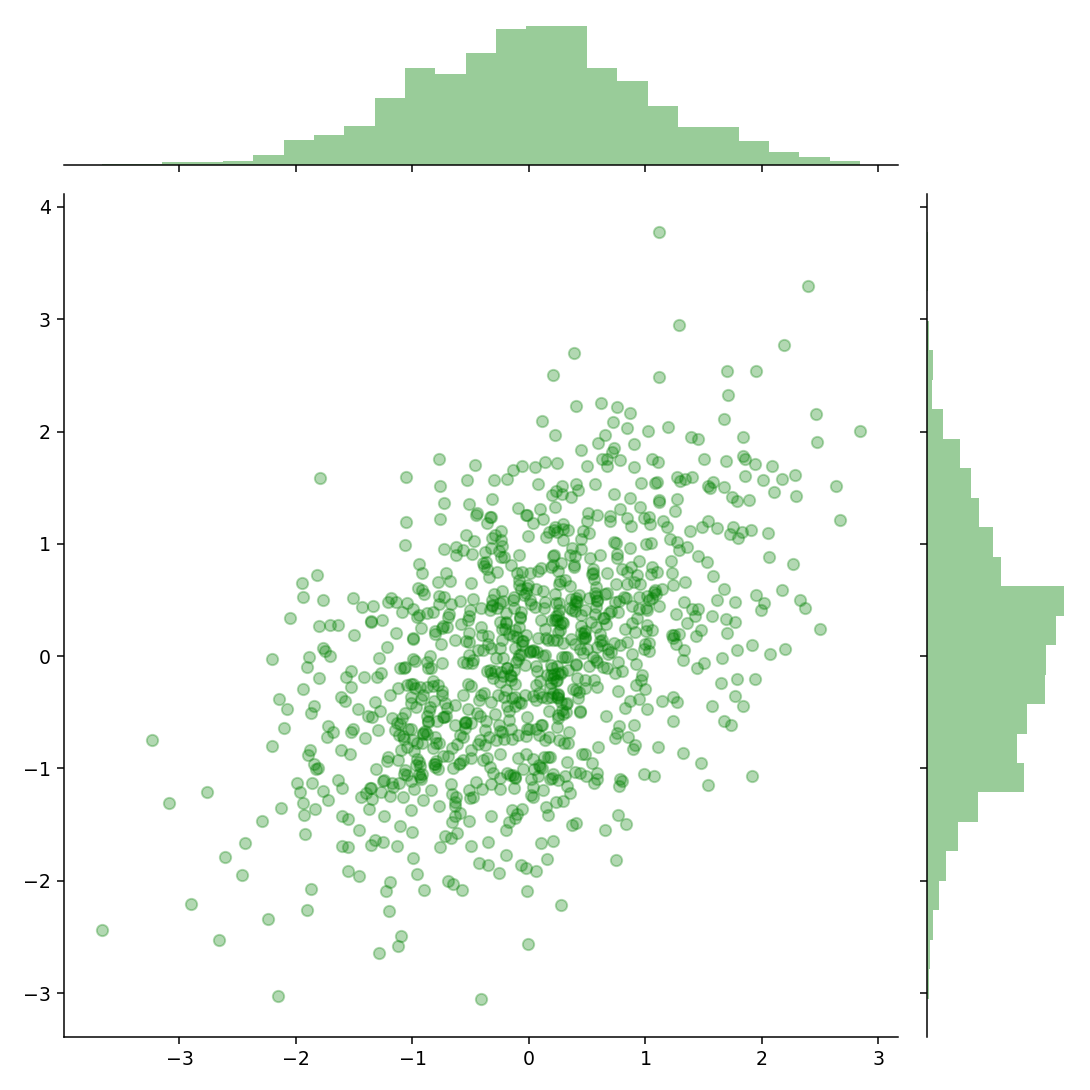

In [115]:
chol = np.linalg.cholesky(sigma)
N = 1000
a,b, = [0]*N, [0]*N
for i in range(N):
    a[i],b[i] = mu + chol @ np.random.normal(size=(2,1))
    
joint = sns.jointplot(x=a, y=b, color='green', alpha=0.3, height=8)
plt.show()



def get_data(i=0):
    x,y = a[:i], b[:i]
    return x,y

# Gibbs sampling

Gibbs sampling draws one of our variables with the others fixed. With our bivariate Gaussian distribution, we get the distribution x given y from this page: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

<IPython.core.display.Javascript object>


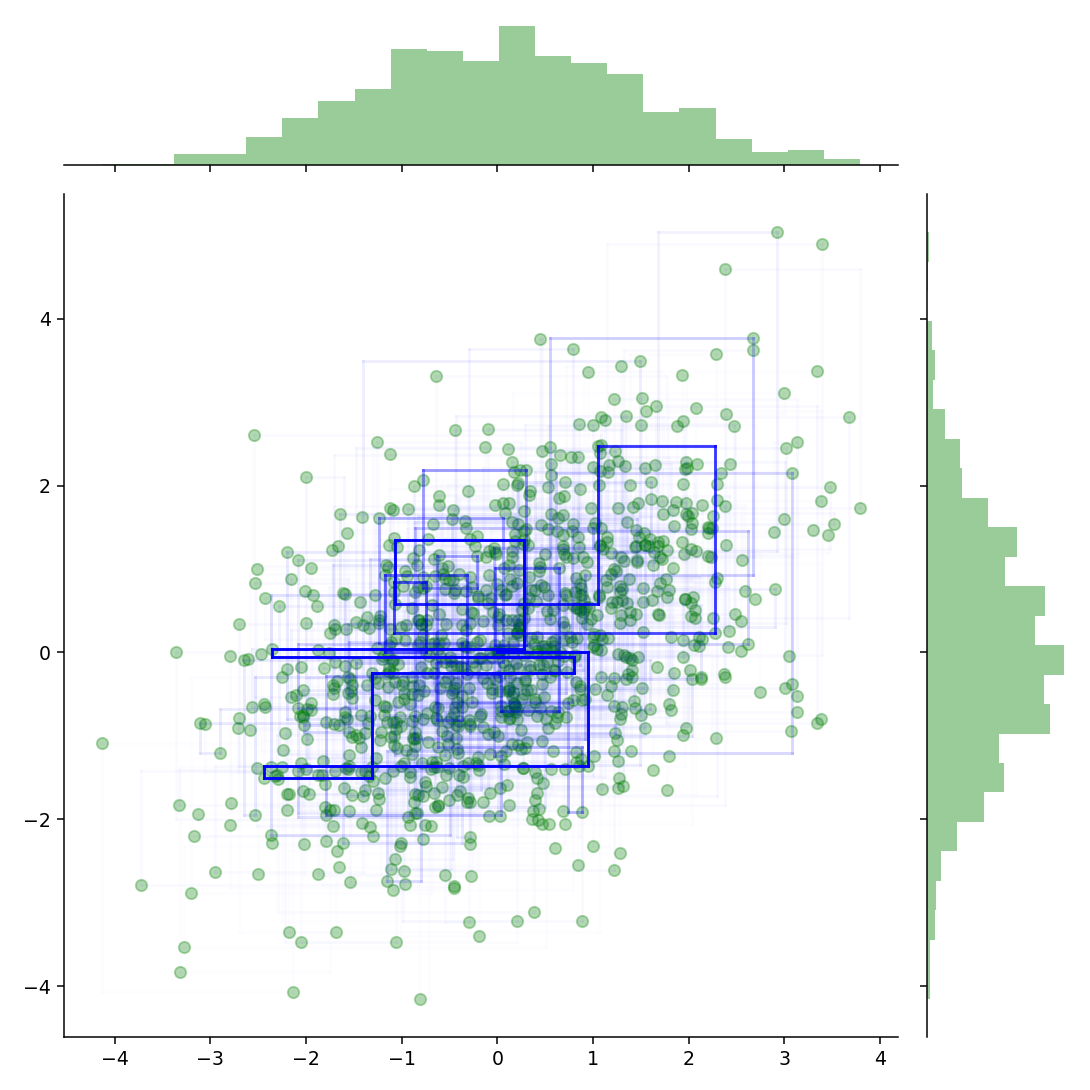

In [83]:
N = 1000
a,b, = [0]*N, [0]*N
for i in range(1, N):
    a_mu_temp = a_mu + cov_a_b * (1/b_sigma) * (b[i-1] - b_mu)
    a_sigma_temp = a_sigma + cov_a_b * (1/b_sigma) * cov_a_b
    a[i] = a_mu_temp + a_sigma_temp * np.random.normal()
    
    b_mu_temp = b_mu + cov_a_b * (1/a_sigma) * (a[i] - a_mu)
    b_sigma_temp = b_sigma + cov_a_b * (1/a_sigma) * cov_a_b
    b[i] = b_mu_temp + b_sigma_temp * np.random.normal()
    
plot = sns.jointplot(x=a, y=b, color='green', alpha=0.3, height=8)

# Plot all transitions of the Gibbs Sampling
for i in range(1,N):
    plot.ax_joint.plot([a[i-1],a[i]], [b[i-1],b[i-1]], 'b-', alpha = min(1,7/i))
    plot.ax_joint.plot([a[i],a[i]], [b[i-1],b[i]], 'b-', alpha = min(1,7/i))
plt.show()

# Metropolis-Hastings Sampling

The Metropolis-Hastings algorithm is the following:

For each new proposal:

* Draw a proposal x' from an easy distribution $q(x'|x)$, for instance q ~ $\mathcal{N}(x,\sigma^{2}I)$

* Accept proposal with probability $min(1, \frac{p(x')q(x|x')}{p(x)q(x'|x)})$

* Otherwise next state stays same as current state

[[1000000.       0.]
 [      0. 1000000.]]
Proba: [[1.59154784e-07]]


<IPython.core.display.Javascript object>


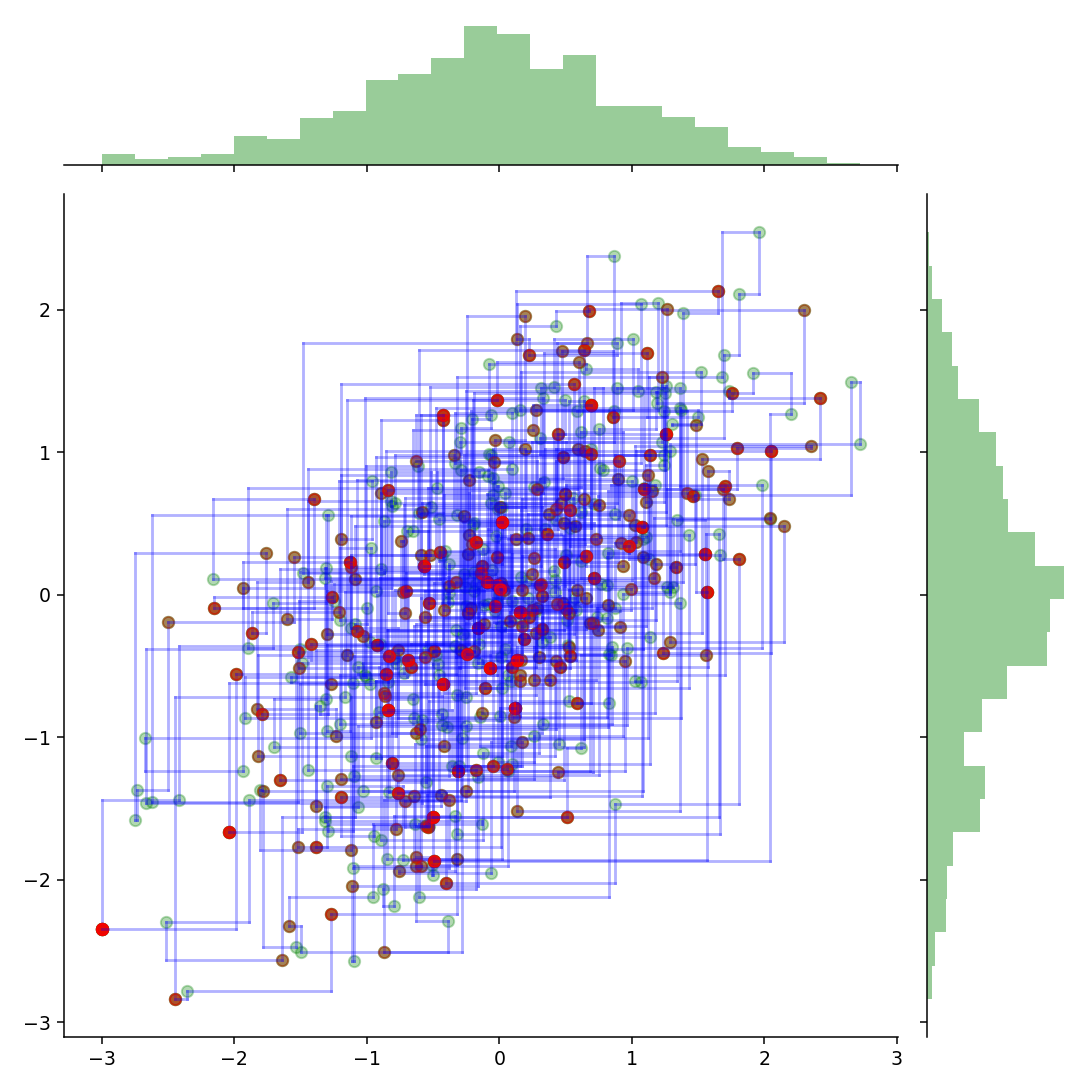

The acceptance ratio is: 0.553


In [132]:
std = 1000
sigma_q = std**2 * np.eye(2)
print(sigma_q)
print('Proba:',p(np.ones((2,1)),np.zeros((2,1)), sigma_q))

def MH_proba(x, x2):
    return min(1, (p(x2, mu, sigma)* p(x, x2, sigma_q)/(p(x, mu, sigma)*p(x2,x, sigma_q)))[0,0])

a = []
b = []
current_point = np.zeros((2,1))
accepted = 0
for i in range(N):
    proposal = current_point + sigma @ np.random.normal(size=(2,1)) 
    proba_acceptance = MH_proba(current_point, proposal)
    if np.random.binomial(1,proba_acceptance):
        current_point = proposal
        accepted+=1
    a.append(current_point[0])
    b.append(current_point[1])
    
plot = sns.jointplot(x=a, y=b, color='green', alpha=0.3, height=8)

for i in range(1,N):
    if (a[i-1]==a[i]) and (b[i-1]==b[i]):
        plot.ax_joint.plot(a[i-1], b[i-1], 'ro', alpha=0.3)
    else:
        plot.ax_joint.plot([a[i-1],a[i]], [b[i-1],b[i-1]], 'b-', alpha = 0.3)
        plot.ax_joint.plot([a[i],a[i]], [b[i-1],b[i]], 'b-', alpha = 0.3)
plt.show()

print('The acceptance ratio is:', accepted/len(a))